In [1]:
# necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os 
import time
from tqdm import tqdm
import pickle

# deep learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torch.autograd import Variable

In [2]:
# a simple cnn architecture
num_class = 10
hidden_sizes = [32, 64, 128]

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, hidden_sizes[0], 3)
        self.conv2 = nn.Conv2d(hidden_sizes[0], hidden_sizes[1], 3)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(hidden_sizes[1] * 12 * 12, hidden_sizes[2])
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_sizes[2], num_class)
        self.out = nn.LogSoftmax(-1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [3]:
# define transformations for the dataset
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

# load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# split train dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# create data loaders
batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [4]:
# training the cnn
num_epochs = 10
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# information
train_losses = []
val_losses = []
test_losses = []
train_accuracy = []  
val_accuracy = []
test_accuracy = []

# training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_acc = correct / total
    train_accuracy.append(train_acc)
    
    # validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_acc = correct/total
        val_accuracy.append(val_acc)
        
    model.eval()
    test_loss = 0.0
    correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
        
            outputs = model(images)
            loss = criterion(outputs, labels)
        
            test_loss += loss.item() * images.size(0)
        
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    
        test_loss /= len(test_loader.dataset)
        test_acc = correct / len(test_loader.dataset)
        test_losses.append(test_loss)
        test_accuracy.append(test_acc)
        
        print(f"\nEpoch [{epoch+1}/{num_epochs}] ")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f}, Val   Accuracy: {val_acc:.4f}")
        print(f"Test  Loss: {test_loss:.4f}, Test  Accuracy: {test_acc:.4f}")


Epoch [1/10] 
Train Loss: 0.3088, Train Accuracy: 0.9060
Val   Loss: 0.0657, Val   Accuracy: 0.9809
Test  Loss: 0.0592, Test  Accuracy: 0.9821

Epoch [2/10] 
Train Loss: 0.1151, Train Accuracy: 0.9665
Val   Loss: 0.0557, Val   Accuracy: 0.9839
Test  Loss: 0.0503, Test  Accuracy: 0.9853

Epoch [3/10] 
Train Loss: 0.0901, Train Accuracy: 0.9736
Val   Loss: 0.0493, Val   Accuracy: 0.9858
Test  Loss: 0.0421, Test  Accuracy: 0.9860

Epoch [4/10] 
Train Loss: 0.0738, Train Accuracy: 0.9776
Val   Loss: 0.0461, Val   Accuracy: 0.9868
Test  Loss: 0.0392, Test  Accuracy: 0.9879

Epoch [5/10] 
Train Loss: 0.0643, Train Accuracy: 0.9808
Val   Loss: 0.0460, Val   Accuracy: 0.9872
Test  Loss: 0.0361, Test  Accuracy: 0.9892

Epoch [6/10] 
Train Loss: 0.0573, Train Accuracy: 0.9826
Val   Loss: 0.0417, Val   Accuracy: 0.9881
Test  Loss: 0.0371, Test  Accuracy: 0.9894

Epoch [7/10] 
Train Loss: 0.0496, Train Accuracy: 0.9849
Val   Loss: 0.0374, Val   Accuracy: 0.9894
Test  Loss: 0.0333, Test  Accuracy:

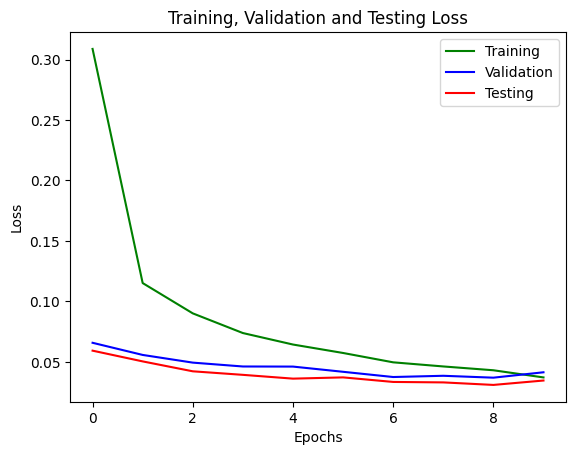

In [5]:
# plotting the training and validation loss
epochs = range(num_epochs)
plt.plot(epochs, train_losses, 'g', label='Training')
plt.plot(epochs, val_losses, 'b', label='Validation')
plt.plot(epochs, test_losses, 'r', label='Testing')
plt.title('Training, Validation and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

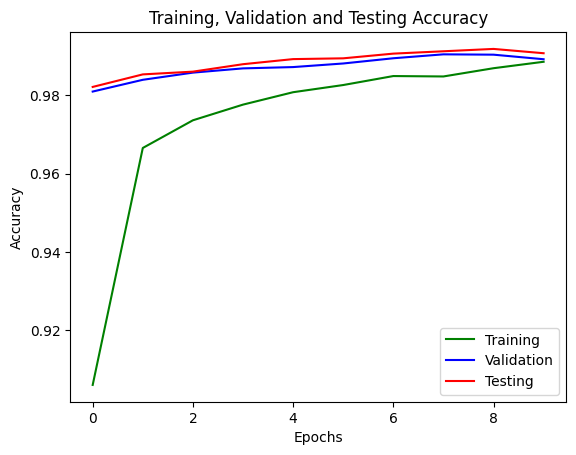

In [6]:
# plotting the training and validation loss
epochs = range(num_epochs)
plt.plot(epochs, train_accuracy, 'g', label='Training')
plt.plot(epochs, val_accuracy, 'b', label='Validation')
plt.plot(epochs, test_accuracy, 'r', label='Testing')
plt.title('Training, Validation and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset
np.random.seed(0)           
tf.random.set_seed(0)       

In [ ]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [ ]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev, interface="autograd")
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [ ]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [ ]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

In [ ]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()